# Dimension Reduction 

## Setup

In [2]:
# Setup ---------------------------------------------------------------

set.seed(141)

library(cluster)   # for silhouette and clustering tools

library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


### 1 PCA on a Simple 2D Example

We start with a simple 2D dataset with correlated variables to visualize what PCA is doing.


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Warning message:
“The `x` argument of `as_tibble.matrix()` must have unique column names if
`.name_repair` is omitted as of tibble 2.0.0.
ℹ Using compatibility `.name_repair`.”


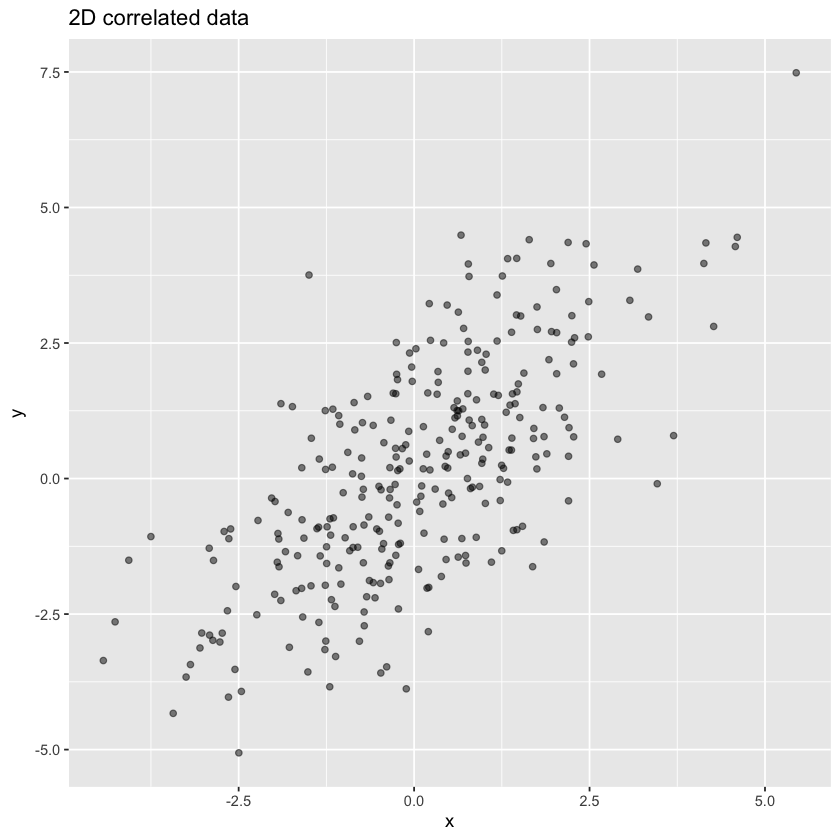

In [3]:
# 1 Generate correlated 2D data 
library(MASS)

Sigma2 <- matrix(c(3, 2.5,
                   2.5, 4), nrow = 2)

df2 <- as_tibble(mvrnorm(300, mu = c(0, 0), Sigma = Sigma2))
colnames(df2) <- c("x", "y")

ggplot(df2, aes(x = x, y = y)) +
  geom_point(alpha = 0.5) +
  labs(title = "2D correlated data",
       x = "x", y = "y")


Visually, the cloud is elongated along a diagonal direction. PCA should find that direction as the first principal component.

In [4]:
# 1.2 Run PCA on the 2D data ----------------------------------------

pca2 <- prcomp(df2, center = TRUE, scale. = FALSE)
summary(pca2)
pca2$rotation   # loadings (directions)


Importance of components:
                          PC1    PC2
Standard deviation     2.4197 0.9927
Proportion of Variance 0.8559 0.1441
Cumulative Proportion  0.8559 1.0000

,PC1,PC2
x,-0.5864029,-0.8100195
y,-0.8100195,0.5864029


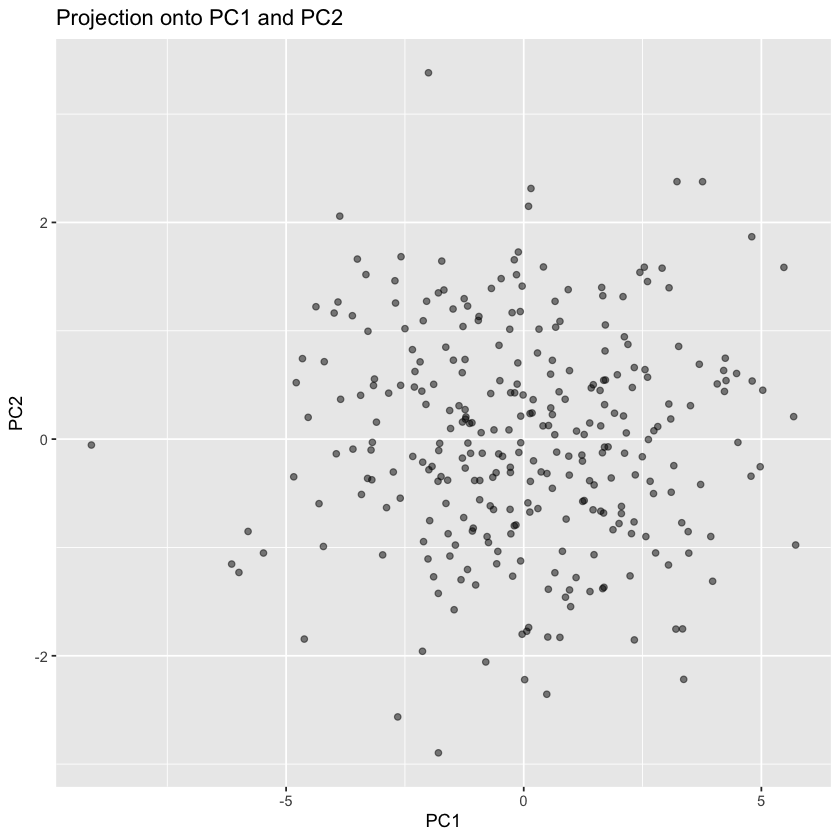

In [5]:
# 1.3 Plot scores in PC space 
scores2 <- as_tibble(pca2$x)

ggplot(scores2, aes(x = PC1, y = PC2)) +
  geom_point(alpha = 0.5) +
  labs(title = "Projection onto PC1 and PC2",
       x = "PC1", y = "PC2")


Warning message in geom_segment(aes(x = center2[1], y = center2[2], xend = center2[1] + :
“All aesthetics have length 1, but the data has 300 rows.
ℹ Did you mean to use `annotate()`?”
Warning message in geom_segment(aes(x = center2[1], y = center2[2], xend = center2[1] + :
“All aesthetics have length 1, but the data has 300 rows.
ℹ Did you mean to use `annotate()`?”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


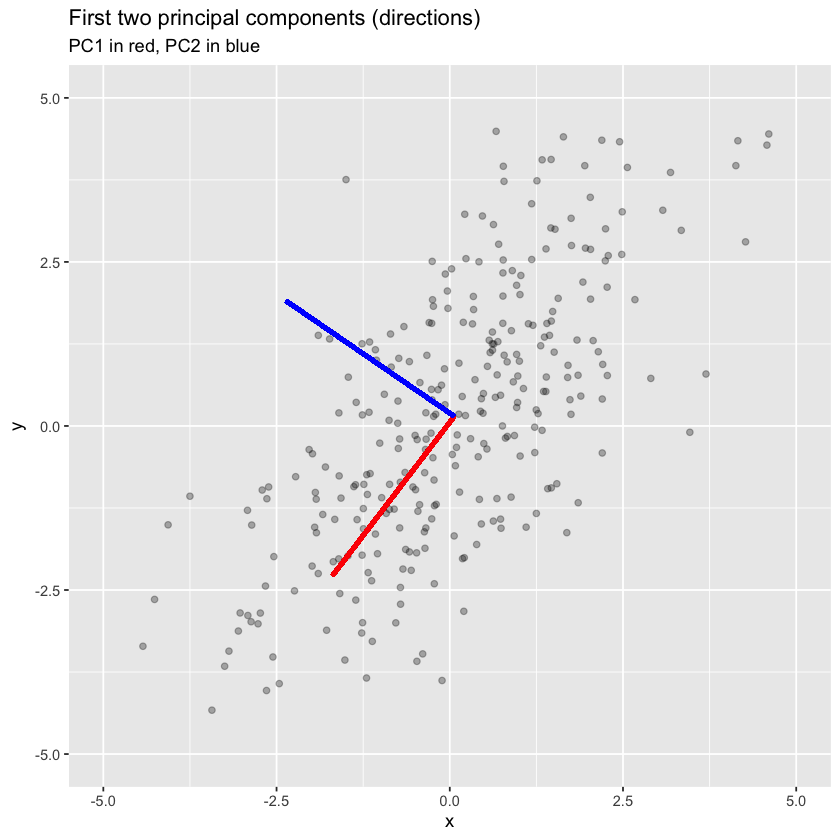

In [6]:
# 1.4 Overlay PC directions on original data 
center2 <- colMeans(df2)

ggplot(df2, aes(x = x, y = y)) +
  geom_point(alpha = 0.3) +
  geom_segment(aes(x = center2[1], y = center2[2],
                   xend = center2[1] + 3 * pca2$rotation[1, 1],
                   yend = center2[2] + 3 * pca2$rotation[2, 1]),
               color = "red", linewidth = 1.2) +
  geom_segment(aes(x = center2[1], y = center2[2],
                   xend = center2[1] + 3 * pca2$rotation[1, 2],
                   yend = center2[2] + 3 * pca2$rotation[2, 2]),
               color = "blue", linewidth = 1.2) +
  labs(title = "First two principal components (directions)",
       subtitle = "PC1 in red, PC2 in blue") +
       xlim(-5, 5) + ylim(-5,5)


### 2 PCA on `iris`

We now apply PCA to the classic `iris` dataset.

In [ ]:
head(iris)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa
6,5.4,3.9,1.7,0.4,setosa


In [ ]:
# 2.1 Prepare the iris data -----------------------------------------

iris_df <- iris |>
  as_tibble()

X_iris <- iris_df |>
  dplyr::select(-Species)
X_iris_scaled <- scale(X_iris)  # standardize all numeric variables

head(X_iris_scaled)


Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
-0.8976739,1.01560199,-1.335752,-1.311052
-1.1392005,-0.13153881,-1.335752,-1.311052
-1.3807271,0.32731751,-1.392399,-1.311052
-1.5014904,0.09788935,-1.279104,-1.311052
-1.0184372,1.24503015,-1.335752,-1.311052
-0.5353840,1.93331463,-1.165809,-1.048667


In [ ]:
# 2.2 Run PCA on scaled iris ----------------------------------------

pca_iris <- prcomp(X_iris_scaled, center = TRUE, scale. = FALSE)
summary(pca_iris)


Importance of components:
                          PC1    PC2     PC3     PC4
Standard deviation     1.7084 0.9560 0.38309 0.14393
Proportion of Variance 0.7296 0.2285 0.03669 0.00518
Cumulative Proportion  0.7296 0.9581 0.99482 1.00000

In [ ]:
# Scree plot: proportion of variance explained 
var_exp <- (pca_iris$sdev)^2
prop_var <- var_exp / sum(var_exp)
cum_var <- cumsum(prop_var)

pca_var_df <- tibble(PC = 1:length(var_exp),
                     prop_var = prop_var,
                     cum_var = cum_var)
pca_var_df


PC,prop_var,cum_var
<int>,<dbl>,<dbl>
1,0.729624454,0.7296245
2,0.228507618,0.9581321
3,0.036689219,0.9948213
4,0.005178709,1.0000000


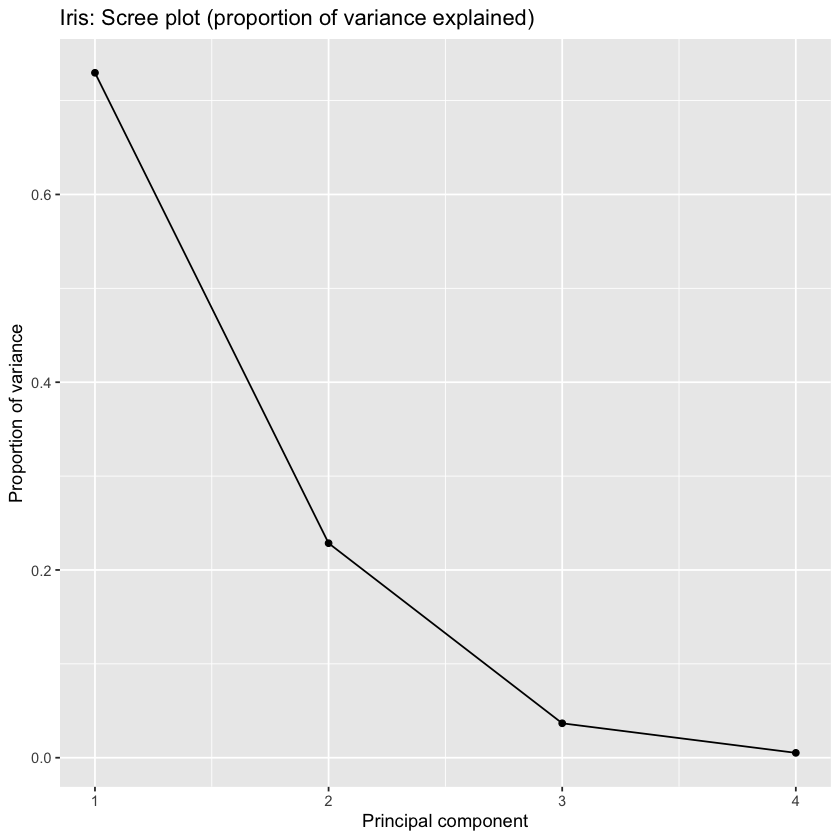

In [ ]:
ggplot(pca_var_df, aes(x = PC, y = prop_var)) +
  geom_line() +
  geom_point() +
  scale_x_continuous(breaks = pca_var_df$PC) +
  labs(title = "Iris: Scree plot (proportion of variance explained)",
       x = "Principal component", y = "Proportion of variance")


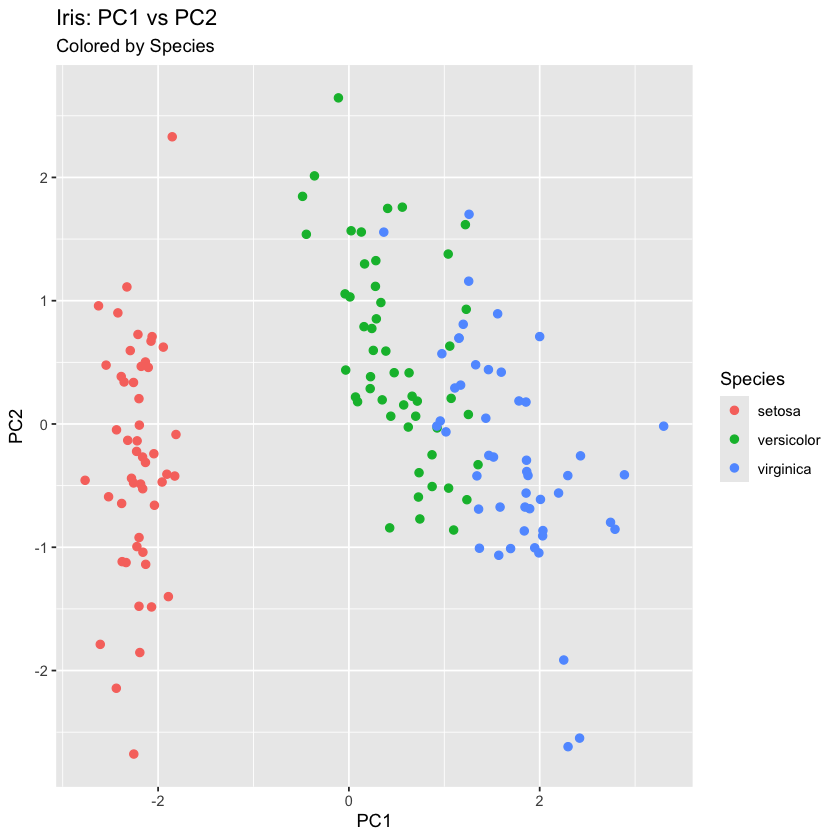

In [ ]:
# 2.3 Scores plot colored by species --------------------------------

pc_scores <- as_tibble(pca_iris$x) |>
  mutate(Species = iris_df$Species)

ggplot(pc_scores, aes(x = PC1, y = PC2, color = Species)) +
  geom_point(size = 2) +
  labs(title = "Iris: PC1 vs PC2",
       subtitle = "Colored by Species")


### 3 PCA on `USArrests`

We next revisit the `USArrests` dataset to see PCA in a higher-dimensional setting.

In [ ]:
# 3.1 Prepare and scale data 

arrests <- USArrests |>
  as_tibble(rownames = "State")

X_arrests <- arrests |>
  dplyr::select(-State)
X_arrests_scaled <- scale(X_arrests)
head(X_arrests_scaled)


Murder,Assault,UrbanPop,Rape
1.24256408,0.7828393,-0.5209066,-0.003416473
0.50786248,1.1068225,-1.2117642,2.484202941
0.07163341,1.4788032,0.9989801,1.042878388
0.23234938,0.2308680,-1.0735927,-0.184916602
0.27826823,1.2628144,1.7589234,2.067820292
0.02571456,0.3988593,0.8608085,1.864967207


In [ ]:
# 3.2 Run PCA --------------------------------------------------------

pca_arrests <- prcomp(X_arrests_scaled, center = TRUE, scale. = FALSE)
summary(pca_arrests)
pca_arrests$rotation   # loadings


Importance of components:
                          PC1    PC2     PC3     PC4
Standard deviation     1.5749 0.9949 0.59713 0.41645
Proportion of Variance 0.6201 0.2474 0.08914 0.04336
Cumulative Proportion  0.6201 0.8675 0.95664 1.00000

,PC1,PC2,PC3,PC4
Murder,-0.5358995,-0.4181809,0.3412327,0.64922780
Assault,-0.5831836,-0.1879856,0.2681484,-0.74340748
UrbanPop,-0.2781909,0.8728062,0.3780158,0.13387773
Rape,-0.5434321,0.1673186,-0.8177779,0.08902432


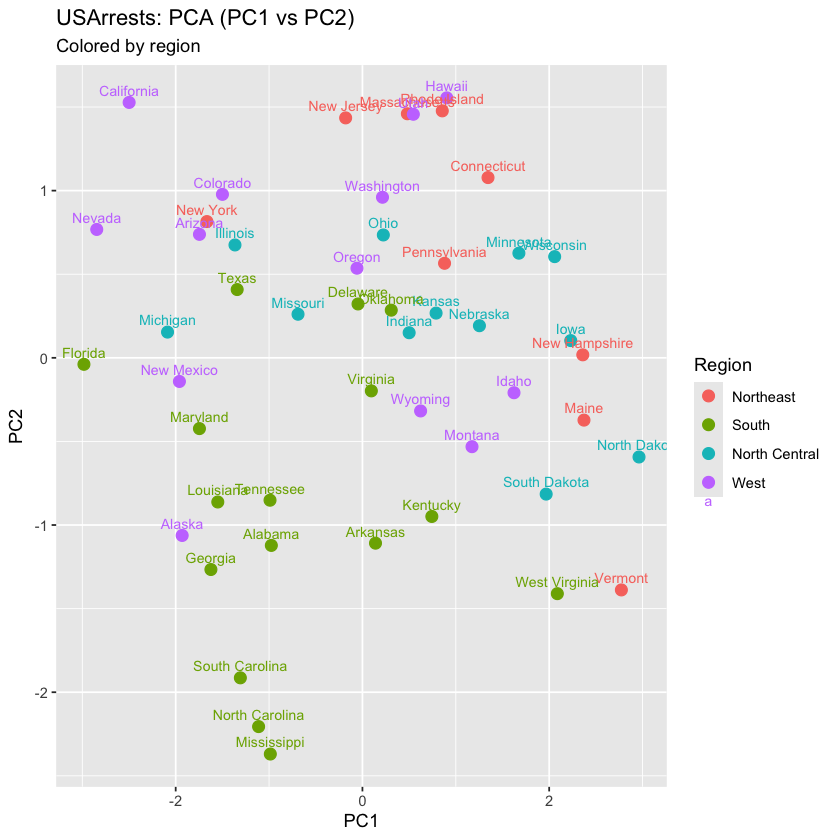

In [ ]:
# 3.3 Plot first two PCs, colored by region -------------------------

pc_arrests <- as_tibble(pca_arrests$x) |>
  mutate(State = arrests$State,
         Region = state.region)

ggplot(pc_arrests, aes(x = PC1, y = PC2, color = Region, label = State)) +
  geom_point(size = 3) +
  geom_text(vjust = -0.7, size = 3) +
  labs(title = "USArrests: PCA (PC1 vs PC2)",
       subtitle = "Colored by region")


### 4 Classical Multidimensional Scaling (MDS) on `USArrests`

Classical MDS is another dimension reduction method based on preserving pairwise distances.

In [ ]:
# 4.1 Distance matrix on scaled USArrests ---------------------------

dist_arrests <- dist(X_arrests_scaled, method = "euclidean")
dist_arrests[1:10]


[1] 2.703754 2.293520 1.289810 3.263110 2.651067 3.215297 2.019293 2.298135
 [9] 1.131435 3.388530

In [ ]:
# 4.2 Classical MDS to 2 dimensions ---------------------------------

mds2 <- cmdscale(dist_arrests, k = 2)
mds_df <- as_tibble(mds2)
colnames(mds_df) <- c("MDS1", "MDS2")

mds_df <- mds_df |>
  mutate(State = arrests$State,
         Region = state.region)
head(mds_df)


MDS1,MDS2,State,Region
<dbl>,<dbl>,<chr>,<fct>
-0.9756604,1.1220012,Alabama,South
-1.9305379,1.0624269,Alaska,West
-1.7454429,-0.7384595,Arizona,West
0.1399989,1.1085423,Arkansas,South
-2.4986128,-1.5274267,California,West
-1.4993407,-0.9776297,Colorado,West


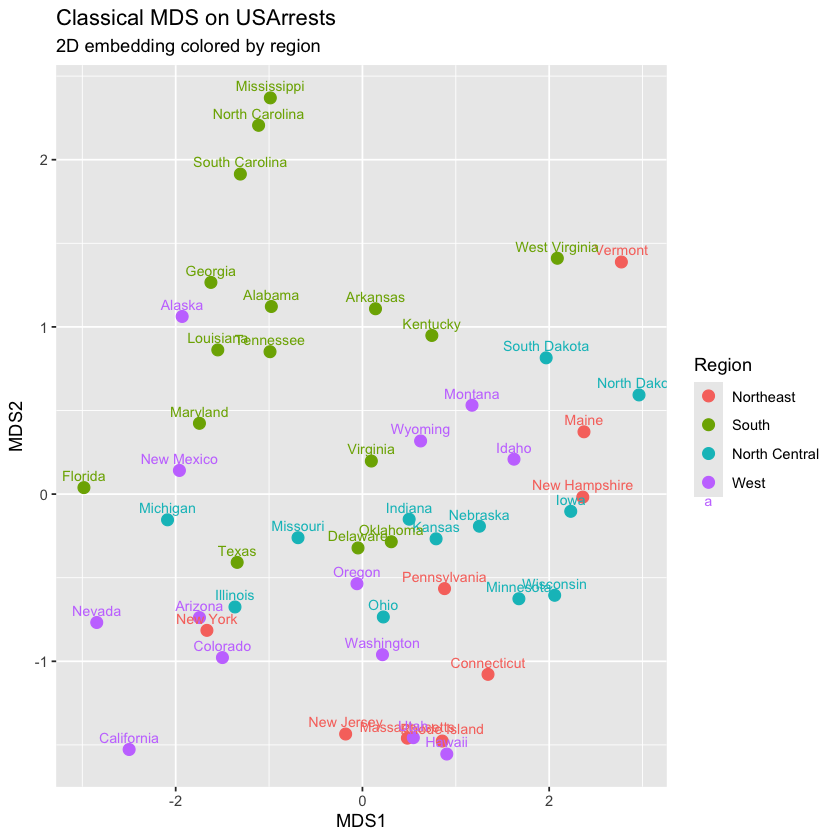

In [ ]:
# 4.3 Plot MDS embedding --------------------------------------------

ggplot(mds_df, aes(x = MDS1, y = MDS2, color = Region, label = State)) +
  geom_point(size = 3) +
  geom_text(vjust = -0.7, size = 3) +
  labs(title = "Classical MDS on USArrests",
       subtitle = "2D embedding colored by region")


# Exercises 

### Exercise 1 PCA and Scree Plot on `mtcars`

1. Use the `mtcars` dataset and scale all numeric variables.
2. Run PCA using `prcomp`.
3. Create a scree plot and compute the cumulative proportion of variance explained.
4. Determine how many PCs are needed to explain roughly 70% and 90% of the variance.


In [ ]:
# Exercise 1 

# Turn mtcars into a tibble

# Standardize mtcars using scale()

# Run PCA on the standardized data

# Results from summary()

In [ ]:
# Extract the variance explained by each PC from pca_mtcars$sdev
# var_exp_m <-  

# turn variance into proportion of variance explained
# prop_var_m <- 

# compute cumulative proportion
# cum_var_m <-  

# Assemble a tibble with PC index, proportion, and cumulative proportion
# pca_m_df <- tibble(
#  PC =  ,
# prop_var = ,
#  cum_var = 
# )


In [ ]:
## 2) mtcars PCA: scree plot 

# ggplot( , aes(x =, y = )) +
#  geom_line() +
#  geom_point() +
#  #  : make x-axis show each PC as a tick mark
#  scale_x_continuous(breaks = ) +
#  labs(
#    title = ,
#    x = ,
#    y = 
#  )


### Exercise 2 Interpreting PCA Loadings on `mtcars`


1. Examine the loadings for PC1 and PC2 from Exercise 1.
2. Identify which variables contribute most to each PC.
3. Give a short interpretation (e.g., "PC1 measures overall power/size").


In [ ]:
# Exercise 2 ----------------------------------------------------------

#  : examine .$rotation and interpret PC1/PC2.


### Exercise 3  PCA and Clustering on `iris`

1. Using the `pca_iris` object from Part A, extract the scores for the first two PCs.
2. Run k-means clustering with K = 3 on these 2D scores.
3. Plot the PC1–PC2 scores colored by the k-means cluster assignments.
4. Compare the clusters to the true species labels.


In [ ]:
# Exercise 3 ----------------------------------------------------------
#  : extract PC1 and PC2 scores from pca_iris$x and convert to tibble
# pc_iris_2d <- as_tibble(  )
# colnames(pc_iris_2d) <- c("PC1", "PC2")

# set.seed(141)

#  : run kmeans with K=3; choose reasonable nstart
# k3_iris <- kmeans(, centers = , nstart = )

#  : attach cluster labels + original species
# pc_iris_clusters <- pc_iris_2d |>
#  mutate(
#    cluster = factor( ),
#    Species = 
#  )

# ggplot(pc_iris_clusters, aesx = , y = , color =) +
#  geom_point(size = 2) +
#  labs(
#    title =,
#    subtitle = 
#  )


In [ ]:
# Compare clusters with true species
# table(cluster = ,
#      Species = )


### Exercise 4 Classical MDS on `USArrests`

1. Using the scaled `USArrests` data from Part A, compute the Euclidean distance matrix (if not already done).
2. Perform classical MDS with `k = 2`.
3. Plot the resulting 2D embedding colored by region.
4. Compare your MDS plot to the PCA PC1–PC2 plot for `USArrests`. Mention one similarity and one difference.


In [ ]:
# Exercise 4 ----------------------------------------------------------

#  : run MDS on USArrests and compare qualitatively to PCA.

#  : compute distance matrix (Euclidean)
# dist_arrests <- dist( , method = )

#  : classical MDS to 2 dimensions
# mds2 <- cmdscale(, k = )

#  : make tibble and name columns
# mds_df <- as_tibble( )
# colnames(mds_df) <- c("MDS1", "MDS2")

#  : add state name + region
# mds_df <- mds_df |>
#  mutate(
#    State =  ,
#    Region =  
#  )

# ggplot(mds_df, aes(x = , y = , color = , label = )) +
# geom_point(size = 3) +
#  geom_text(vjust = -0.7, size = 3) +
#  labs(title = )